# Elastic Events Tagging

In this notebook we perform the full selection of **proton–proton elastic scattering events** from the TOTEM open data.  
The procedure starts from *elastic candidates*, i.e. events that contain valid tracks in the Roman Pot (RP) detectors and satisfy the basic **diagonality requirement** (a proton track is consistently observed in opposite detector arms).

From this candidate sample, we apply a sequence of **elastic selection cuts** that enforce the expected kinematic correlations between the left and right arms, as well as between the near and far RP units. These cuts are designed to:
- ensure collinearity of tracks measured in the two arms,
- validate the reconstructed vertex position,
- suppress events with non-elastic characteristics (e.g. diffractive processes, beam halo background),
- and isolate a clean elastic sample suitable for physics analysis.

Each cut is associated with a physical observable (such as scattering angle or vertex position) and a tolerance window (typically ±3σ, based on the measured RMS of the distribution). The impact of every cut on the dataset is shown in the following plots, both to demonstrate their efficiency and to illustrate the underlying physics constraints.

By the end of this notebook, we obtain a high-purity set of elastic scattering events that can be used to measure the differential elastic cross section, $d\sigma/dt$, and to extract key physics quantities such as the slope parameter $B$ and, via the optical theorem, the total cross section.


## Data Files Loading

In [1]:
import ROOT 
from pathlib import Path

ROOT.EnableImplicitMT()


dataset1 = ROOT.ROOT.RDataFrame("TotemNtuple", "dataset1_diagonals.root")
dataset2 = ROOT.ROOT.RDataFrame("TotemNtuple", "dataset2_diagonals.root")
dataset3 = ROOT.ROOT.RDataFrame("TotemNtuple", "dataset3_diagonals.root")


dataset1.Describe()

Dataframe from TChain TotemNtuple in file dataset1_diagonals.root

Property                Value
--------                -----
Columns in total           55
Columns from defines        0
Event loops run             0
Processing slots           10

Column                  Type            Origin
------                  ----            ------
bunch_num               UInt_t          Dataset
dataset_num             Int_t           Dataset
diagonal                Bool_t          Dataset
event_num               UInt_t          Dataset
input_status_bits       UInt_t          Dataset
run_no                  UInt_t          Dataset
t                       Double_t        Dataset
th                      Double_t        Dataset
th_x                    Double_t        Dataset
th_x_L                  Double_t        Dataset
th_x_R                  Double_t        Dataset
th_y                    Double_t        Dataset
th_y_L                  Double_t        Dataset
th_y_R                  Double_t  

## Selection Criteria

### The Elastic Selection Cuts

In TOTEM, not every proton track seen in the Roman Pots (RPs) comes from **elastic scattering**.  
There are many **background sources** (beam–halo, diffractive events, inelastic fragments, detector noise).  
To separate real elastic events, we apply **selection cuts**.

- Superscripts **R** and **L** refer to the **right (56)** and **left (45)** arms of the detector. **N** (near) and **F** (far) refer to the RP units within each arm (the detectors are placed about 5 m apart).

- A true elastic proton travels along the beam line, enters the Near RP, and a few meters later also passes through the Far RP. Thus, the measured positions must be correlated:  

$$y_F \approx (1 + \alpha)\, y_N$$

where the constant $\alpha = LF_y/LN_y − 1 ≈ 0.11$  corrects for the small optics asymmetry between near and far detectors.

- In an elastic event, **both scattered protons** (one to the left arm, one to the right arm) must appear. Their scattering angles are nearly mirror–symmetric. This symmetry provides an additional consistency check.

- The right-most column of Tab 1 shows the **RMS $(σ)$** of the distribution of each cut variable. All cuts are applied at the $3σ$ level [[1]](https://iopscience.iop.org/article/10.1209/0295-5075/101/21002#epl15159s5-2), meaning that only events within ±3 standard deviations of the expected elastic correlation are accepted. This reduces background while keeping almost all true elastic events.



**Table 1.** The elastic selection cuts.

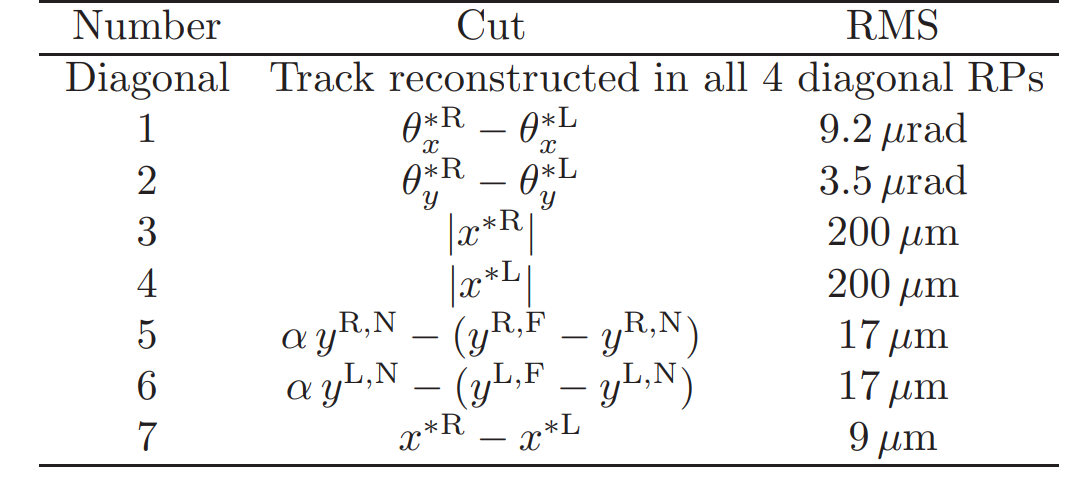

In the TOTEM analysis, each **elastic selection cut** is represented by a mathematical inequality:

$$
f(\text{track variables}) - C < 3\sigma
$$

where $C$ is the *cut constant*. $C$ is a small alignment/optics offset (dataset–dependent). It recenters the distribution so that genuine elastic events fall around zero difference:

- Plot the distribution of each cut variable.
- Measure the mean (center) of the elastic peak.
- Assign that mean as the cut constant $C$.
- Apply the cut at $±3σ$ around this value.

Because alignment and optics can vary from dataset to dataset, the constants are slightly different for each.

In [2]:
cut_constants_dataset1 = {
    "cut_1_diag45b56t_const" : "+0.3E-6",
    "cut_1_diag45t56b_const" : "+0.3E-6",

    "cut_5_diag45b56t_const" : "+2.5E-3",
    "cut_5_diag45t56b_const" : "+6.3E-3",

    "cut_6_diag45b56t_const" : "+7E-3",
    "cut_6_diag45t56b_const" : "+14.5E-3",

    "cut_7_diag45b56t_const" : "-13.9",
    "cut_7_diag45t56b_const" : "-16"
}

cut_constants_dataset2 = {
    "cut_1_diag45b56t_const" : "-1.7E-6",
    "cut_1_diag45t56b_const" : "+0.9E-6",

    "cut_5_diag45b56t_const" : "+2.5E-3",
    "cut_5_diag45t56b_const" : "-3.1E-3",

    "cut_6_diag45b56t_const" : "+6.9E-3",
    "cut_6_diag45t56b_const" : "+18.9E-3",

    "cut_7_diag45b56t_const" : "-11.7",
    "cut_7_diag45t56b_const" : "-13.2"
}

cut_constants_dataset3 = {
    "cut_1_diag45b56t_const" : "+0.8E-6",
    "cut_1_diag45t56b_const" : "-1.6E-6",

    "cut_5_diag45b56t_const" : "+2.9E-3",
    "cut_5_diag45t56b_const" : "-5.2E-3",

    "cut_6_diag45b56t_const" : "+6.2E-3",
    "cut_6_diag45t56b_const" : '+17.3E-3',

    "cut_7_diag45b56t_const" : "-12.4",
    "cut_7_diag45t56b_const" : "-16.6"
}

In [3]:
dataset1_cut_constants = dataset1.Define("cut_1_diag45b56t_const", cut_constants_dataset1["cut_1_diag45b56t_const"])\
                                    .Define("cut_1_diag45t56b_const", cut_constants_dataset1["cut_1_diag45t56b_const"])\
                                    .Define("cut_5_diag45b56t_const", cut_constants_dataset1["cut_5_diag45b56t_const"])\
                                    .Define("cut_5_diag45t56b_const", cut_constants_dataset1["cut_5_diag45t56b_const"])\
                                    .Define("cut_6_diag45b56t_const", cut_constants_dataset1["cut_6_diag45b56t_const"])\
                                    .Define("cut_6_diag45t56b_const", cut_constants_dataset1["cut_6_diag45t56b_const"])\
                                    .Define("cut_7_diag45b56t_const", cut_constants_dataset1["cut_7_diag45b56t_const"])\
                                    .Define("cut_7_diag45t56b_const", cut_constants_dataset1["cut_7_diag45t56b_const"])

dataset2_cut_constants = dataset2.Define("cut_1_diag45b56t_const", cut_constants_dataset2["cut_1_diag45b56t_const"])\
                                    .Define("cut_1_diag45t56b_const", cut_constants_dataset2["cut_1_diag45t56b_const"])\
                                    .Define("cut_5_diag45b56t_const", cut_constants_dataset2["cut_5_diag45b56t_const"])\
                                    .Define("cut_5_diag45t56b_const", cut_constants_dataset2["cut_5_diag45t56b_const"])\
                                    .Define("cut_6_diag45b56t_const", cut_constants_dataset2["cut_6_diag45b56t_const"])\
                                    .Define("cut_6_diag45t56b_const", cut_constants_dataset2["cut_6_diag45t56b_const"])\
                                    .Define("cut_7_diag45b56t_const", cut_constants_dataset2["cut_7_diag45b56t_const"])\
                                    .Define("cut_7_diag45t56b_const", cut_constants_dataset2["cut_7_diag45t56b_const"])

dataset3_cut_constants = dataset3.Define("cut_1_diag45b56t_const", cut_constants_dataset3["cut_1_diag45b56t_const"])\
                                    .Define("cut_1_diag45t56b_const", cut_constants_dataset3["cut_1_diag45t56b_const"])\
                                    .Define("cut_5_diag45b56t_const", cut_constants_dataset3["cut_5_diag45b56t_const"])\
                                    .Define("cut_5_diag45t56b_const", cut_constants_dataset3["cut_5_diag45t56b_const"])\
                                    .Define("cut_6_diag45b56t_const", cut_constants_dataset3["cut_6_diag45b56t_const"])\
                                    .Define("cut_6_diag45t56b_const", cut_constants_dataset3["cut_6_diag45t56b_const"])\
                                    .Define("cut_7_diag45b56t_const", cut_constants_dataset3["cut_7_diag45b56t_const"])\
                                    .Define("cut_7_diag45t56b_const", cut_constants_dataset3["cut_7_diag45t56b_const"])


# these columns are useful during dataprocessing, but won't be used in the final analysis, therefore they are not saved in the output file
cut_helper_columns = {"cut_1_diag45b56t_const", "cut_1_diag45t56b_const", "cut_5_diag45b56t_const", "cut_5_diag45t56b_const",
                     "cut_6_diag45b56t_const", "cut_6_diag45t56b_const", "cut_7_diag45b56t_const", "cut_7_diag45t56b_const"}

### Cut Expressions

- **Cuts 1 & 2** → enforce left–right angular symmetry, removing **diffractive/inelastic** contamination.  
- **Cuts 3 & 4** → enforce vertex consistency, removing **beam–halo and noise**.  
- **Cuts 5 & 6** → enforce near–far correlations, removing **random or secondary tracks**.  
- **Cut 7** → enforces global vertex agreement, removing **pile-up and residual mismatches**.

In [4]:
# cut 1 applied with RMS of 9.2urad at 3 sigma level
cut_1_diag45b56t_expression = f"abs(th_x_R - th_x_L - cut_1_diag45b56t_const) < 3 * 9.2E-6"
cut_1_diag45t56b_expression = f"abs(th_x_R - th_x_L - cut_1_diag45t56b_const) < 3 * 9.2E-6"
cut_1_expression = f"((diagonal == 1) && {cut_1_diag45b56t_expression}) || ((diagonal == 0) && {cut_1_diag45t56b_expression})", "Cut 1"

# cut 2 applied with RMS of 3.5urad at 3 sigma level
cut_2_expression = f"abs(th_y_R - th_y_L) < 3 * 3.5E-6", "Cut 2"

# cut 3 and cut 4 applied with RMS of 200 um (==0.2 mm) at 3 sigma level, TODO(done) describe others as well with the units
cut_3_expression = f"abs(vtx_x_R) < 3 * 0.2", "Cut 3"
cut_4_expression = f"abs(vtx_x_L) < 3 * 0.2", "Cut 4"

# cut 5 and cut 6 applied with RMS of 17 um (==0.017 mm) at 3 sigma level,
cut_5_diag45b56t_expression = f"abs(-0.1073 * track_rp_120_y + (track_rp_124_y - track_rp_120_y) + cut_5_diag45b56t_const) < 3 * 0.017"
cut_5_diag45t56b_expression = f"abs(-0.1073 * track_rp_121_y + (track_rp_125_y - track_rp_121_y) + cut_5_diag45t56b_const) < 3 * 0.017"
cut_5_expression = f"((diagonal == 1) && {cut_5_diag45b56t_expression}) || ((diagonal == 0) && {cut_5_diag45t56b_expression})", "Cut 5"

cut_6_diag45b56t_expression = f"abs(-0.1073 * track_rp_21_y + (track_rp_25_y - track_rp_21_y) + cut_6_diag45b56t_const) < 3 * 0.017"
cut_6_diag45t56b_expression = f"abs(-0.1073 * track_rp_20_y + (track_rp_24_y - track_rp_20_y) + cut_6_diag45t56b_const) < 3 * 0.017"
cut_6_expression = f"((diagonal == 1) && {cut_6_diag45b56t_expression}) || ((diagonal == 0) && {cut_6_diag45t56b_expression})", "Cut 6"

# cut 7 applied with RMS of 9 um (==9e-3 mm) at 3 sigma level,
cut_7_diag45b56t_expression = f"abs(cut_7_diag45b56t_const * th_x + (vtx_x_R - vtx_x_L)) < 3 * 9E-3"
cut_7_diag45t56b_expression = f"abs(cut_7_diag45t56b_const * th_x + (vtx_x_R - vtx_x_L)) < 3 * 9E-3"
cut_7_expression = f"((diagonal == 1) && {cut_7_diag45b56t_expression}) || ((diagonal == 0) && {cut_7_diag45t56b_expression})", "Cut 7"



* Below we can see the **±3σ window** is applied around the center of the distribution. The red vertical lines mark this acceptance region. Events within these boundaries are tagged as consistent with elastic scattering, while events outside are rejected. 

In [ ]:
keep = []

def plot_cut_variable(df, expr, sigma, title="dist", x_label="", nbins=200, xmin=-5, xmax=5):

    tmp_col = "__cut_var__"
    hdf = df.Define(tmp_col, expr)
    h = hdf.Histo1D(ROOT.RDF.TH1DModel("h_cut", f"{title};{x_label};Events", nbins, xmin, xmax), tmp_col)

    c = ROOT.TCanvas("cut_dist", title, 900, 600)
    ROOT.gPad.SetGrid()
    h.SetLineWidth(2)
    h.Draw("HIST")
    ROOT.gPad.Update()

    y_min, y_max = ROOT.gPad.GetUymin(), ROOT.gPad.GetUymax()

    # ±3σ sınırları (kırmızı çizgiler)
    for xline in (-3*sigma, 3*sigma):
        ln = ROOT.TLine(xline, y_min, xline, y_max)
        ln.SetLineColor(ROOT.kRed)
        ln.SetLineWidth(3)
        ln.SetLineStyle(2)
        ln.Draw("same")
        keep.append(ln)

    c.Modified(); c.Update()
    return c, h.GetPtr()

#Select the parameters manually for each cut.
expr_cut = ("( (th_x_R - th_x_L) - (diagonal==1 ? cut_1_diag45b56t_const : cut_1_diag45t56b_const) ) * 1e6")
sigma = 9.2
df_for_cut = dataset3_cut_constants

canvas_cut1, hist_cut1 = plot_cut_variable(
    df=df_for_cut,
    expr=expr_cut,
    sigma=sigma,
    title="cut 1 (right dist)",
    x_label="#theta_{x}^{*R} - #theta_{x}^{*L}  [#murad]",
    nbins=160, xmin=-50, xmax=50)


**Figure 1.** Cut distribution

### Applying Defined Cuts

In [6]:
dataset1_cuts_applied = dataset1_cut_constants.Filter(*cut_1_expression)\
                                .Filter(*cut_2_expression)\
                                .Filter(*cut_3_expression)\
                                .Filter(*cut_4_expression)\
                                .Filter(*cut_5_expression)\
                                .Filter(*cut_6_expression)\
                                .Filter(*cut_7_expression)\

dataset1_cuts_applied.Report().Print()

Cut 1     : pass=881298     all=918771     -- eff=95.92 % cumulative eff=95.92 %
Cut 2     : pass=872752     all=881298     -- eff=99.03 % cumulative eff=94.99 %
Cut 3     : pass=869877     all=872752     -- eff=99.67 % cumulative eff=94.68 %
Cut 4     : pass=867454     all=869877     -- eff=99.72 % cumulative eff=94.41 %
Cut 5     : pass=861561     all=867454     -- eff=99.32 % cumulative eff=93.77 %
Cut 6     : pass=855154     all=861561     -- eff=99.26 % cumulative eff=93.08 %
Cut 7     : pass=849228     all=855154     -- eff=99.31 % cumulative eff=92.43 %


In [7]:
dataset2_cuts_applied = dataset2_cut_constants.Filter(*cut_1_expression)\
                                .Filter(*cut_2_expression)\
                                .Filter(*cut_3_expression)\
                                .Filter(*cut_4_expression)\
                                .Filter(*cut_5_expression)\
                                .Filter(*cut_6_expression)\
                                .Filter(*cut_7_expression)\

dataset2_cuts_applied.Report().Print()

Cut 1     : pass=124911     all=130941     -- eff=95.39 % cumulative eff=95.39 %
Cut 2     : pass=123256     all=124911     -- eff=98.68 % cumulative eff=94.13 %
Cut 3     : pass=122032     all=123256     -- eff=99.01 % cumulative eff=93.20 %
Cut 4     : pass=120956     all=122032     -- eff=99.12 % cumulative eff=92.37 %
Cut 5     : pass=120053     all=120956     -- eff=99.25 % cumulative eff=91.68 %
Cut 6     : pass=118997     all=120053     -- eff=99.12 % cumulative eff=90.88 %
Cut 7     : pass=117588     all=118997     -- eff=98.82 % cumulative eff=89.80 %


In [8]:
dataset3_cuts_applied = dataset3_cut_constants.Filter(*cut_1_expression)\
                                .Filter(*cut_2_expression)\
                                .Filter(*cut_3_expression)\
                                .Filter(*cut_4_expression)\
                                .Filter(*cut_5_expression)\
                                .Filter(*cut_6_expression)\
                                .Filter(*cut_7_expression)\
                                
dataset3_cuts_applied.Report().Print()

Cut 1     : pass=101236     all=107041     -- eff=94.58 % cumulative eff=94.58 %
Cut 2     : pass=99346      all=101236     -- eff=98.13 % cumulative eff=92.81 %
Cut 3     : pass=95759      all=99346      -- eff=96.39 % cumulative eff=89.46 %
Cut 4     : pass=93704      all=95759      -- eff=97.85 % cumulative eff=87.54 %
Cut 5     : pass=92365      all=93704      -- eff=98.57 % cumulative eff=86.29 %
Cut 6     : pass=91523      all=92365      -- eff=99.09 % cumulative eff=85.50 %
Cut 7     : pass=89819      all=91523      -- eff=98.14 % cumulative eff=83.91 %


## Presenting Results of the Cuts

**-> selecting one of 3 datasets**

The following plots are displayed for a dataset that one can choose by changing the variable in the cell below to 1,2 or 3. Only events that meet the diagonality requirement are shown on 'before' histograms.

In [9]:
dataset_number = 3

In [10]:
if not isinstance(dataset_number, int) or not (1 <= dataset_number <= 3):
    raise ValueError("Dataset number must be an integer 1 or 2 or 3")

datasets = (dataset1, dataset1_cuts_applied), (dataset2, dataset2_cuts_applied), (dataset3, dataset3_cuts_applied)

dataset, dataset_after_cuts = datasets[dataset_number - 1]

### Visualization of the Cuts

In the special LHC optics configuration ($\beta^* = 90 \ \text{m}$), the effective length in the vertical direction ($L_y$) is large, while in the horizontal direction ($L_x$) it is small. This makes the detectors much more sensitive to vertical scattering angles, while horizontal scattering is measured with lower sensitivity. As a result, most elastic protons are detected in the vertical Roman Pots, while the horizontal Pots register only a very small fraction of events. For this reason, in the following plots we focus exclusively on the vertical Pots and exclude the horizontal ones.

#### 1st Cut - Left/Right Horizontal Angle Collinearity ($\theta_x$)

In elastic scattering, the two protons measured in the right (R) and left (L) arms are **collinear** in the horizontal plane. $\theta_x^{*R}$ and $\theta_x^{*L}$ should be (nearly) equal once alignment is accounted for. Small residuals are expected from beam divergence and detector resolution.

General equation:  
$$\theta_x^{*R} - \theta_x^{*L} \;\approx\; C_1$$

Cut applied as:  
$$
|\theta_x^{*R} - \theta_x^{*L} - C_1| < 3\sigma
$$ 
with $\sigma = 9.2~\mu\text{rad}$.

This cut enforces **left–right angular consistency in x**. Events failing it typically come from non-elastic backgrounds (e.g. diffractive/inelastic or halo) that do not satisfy the elastic kinematics.

In [11]:
th_x_r_l_comp = dataset.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{x}}^{{*R}} vs #theta_{{x}}^{{*L}};#theta_{{x}}^{{*R}} [ #murad];#theta_{{x}}^{{*L}} [ #murad]", 
     100, -0.0003, 0.0003, 100, -0.0002, 0.0002), "th_x_R", "th_x_L")

th_x_r_l_comp_after_cut = dataset_after_cuts.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{x}}^{{*R}} vs #theta_{{x}}^{{*L}} after the cuts;#theta_{{x}}^{{*R}} [ #murad];#theta_{{x}}^{{*L}} [ #murad]", 
     100, -0.0003, 0.0003, 100, -0.0002, 0.0002), "th_x_R", "th_x_L")

canvas_th_x_r_l = ROOT.TCanvas("canvas", "2D Histogram", 1400, 600)
canvas_th_x_r_l.Divide(2,1)

canvas_th_x_r_l.cd(1) 
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_x_r_l_comp.Draw("COLZ")
th_x_r_l_comp.SetStats(0)
th_x_r_l_comp.GetYaxis().SetTitleOffset(1.3)
th_x_r_l_comp.GetXaxis().SetLimits(th_x_r_l_comp.GetXaxis().GetXmin() * 1e6, th_x_r_l_comp.GetXaxis().GetXmax() * 1e6)
th_x_r_l_comp.GetYaxis().SetLimits(th_x_r_l_comp.GetYaxis().GetXmin() * 1e6, th_x_r_l_comp.GetYaxis().GetXmax() * 1e6)


canvas_th_x_r_l.cd(2)  
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_x_r_l_comp_after_cut.Draw("COLZ")
th_x_r_l_comp_after_cut.SetStats(0)
th_x_r_l_comp_after_cut.GetYaxis().SetTitleOffset(1.3)
th_x_r_l_comp_after_cut.GetXaxis().SetLimits(th_x_r_l_comp_after_cut.GetXaxis().GetXmin() * 1e6, th_x_r_l_comp_after_cut.GetXaxis().GetXmax() * 1e6)
th_x_r_l_comp_after_cut.GetYaxis().SetLimits(th_x_r_l_comp_after_cut.GetYaxis().GetXmin() * 1e6, th_x_r_l_comp_after_cut.GetYaxis().GetXmax() * 1e6)


canvas_th_x_r_l.Draw()


**Figure 2.** Correlation between the horizontal scattering angle projections reconstructed by using information from the left and right units. 

#### 2nd Cut – Left/Right Vertical Angle Collinearity ($\theta_y$)
Similarly to the first cut, it is also a requirement for the reconstructed tracks to be collinear between the left and right arms. 

$$\theta_y^{*R} + \theta_y^{*L} \;\approx\; 0$$

Cut applied as:  
$$
|\theta_y^{*R} - \theta_y^{*L}| < 3\sigma
$$
with $\sigma = 3.5~\mu\text{rad}$. For the vertical angle difference, no constant is needed since in the vertical plane, the two protons scatter almost perfectly **mirror-symmetric**. As a result, the distribution is already centered around zero.  


In [12]:
th_y_r_l_comp = dataset.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{y}}^{{*R}} vs #theta_{{y}}^{{*L}};#theta_{{y}}^{{*R}} [ #murad];#theta_{{y}}^{{*L}} [ #murad]", 
     100, -0.00015, 0.00015, 100, -0.00015, 0.00015), "th_y_R", "th_y_L")

th_y_r_l_comp_after_cut = dataset_after_cuts.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{y}}^{{*R}} vs #theta_{{y}}^{{*L}} after the cuts;#theta_{{y}}^{{*R}} [ #murad];#theta_{{y}}^{{*L}} [ #murad]", 
     100, -0.00015, 0.00015, 100, -0.00015, 0.00015), "th_y_R", "th_y_L")

canvas_th_y_r_l = ROOT.TCanvas("canvas", "2D Histogram", 1400, 600)
canvas_th_y_r_l.Divide(2,1)

canvas_th_y_r_l.cd(1) 
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_y_r_l_comp.Draw("COLZ")
th_y_r_l_comp.SetStats(0)
th_y_r_l_comp.GetYaxis().SetTitleOffset(1.3)
th_y_r_l_comp.GetXaxis().SetLimits(th_y_r_l_comp.GetXaxis().GetXmin() * 1e6, th_y_r_l_comp.GetXaxis().GetXmax() * 1e6)
th_y_r_l_comp.GetYaxis().SetLimits(th_y_r_l_comp.GetYaxis().GetXmin() * 1e6, th_y_r_l_comp.GetYaxis().GetXmax() * 1e6)


canvas_th_y_r_l.cd(2)  
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_y_r_l_comp_after_cut.Draw("COLZ")
th_y_r_l_comp_after_cut.SetStats(0)
th_y_r_l_comp_after_cut.GetYaxis().SetTitleOffset(1.3)
th_y_r_l_comp_after_cut.GetXaxis().SetLimits(th_y_r_l_comp_after_cut.GetXaxis().GetXmin() * 1e6, th_y_r_l_comp_after_cut.GetXaxis().GetXmax() * 1e6)
th_y_r_l_comp_after_cut.GetYaxis().SetLimits(th_y_r_l_comp_after_cut.GetYaxis().GetXmin() * 1e6, th_y_r_l_comp_after_cut.GetYaxis().GetXmax() * 1e6)

canvas_th_y_r_l.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 3.** Correlation between the vertical scattering angle projections reconstructed by the left and right units. The lower parts of the plots correspond to the 45 top–56 bottom topology, while the upper part corresponds to the 45 bottom–56 top topology.

#### Cuts 3, 4 & 7 – Vertex Consistency 

- Cut 3: $|vtx_x^R| < 3\sigma$, with $\sigma = 0.2 \ \text{mm}$  
- Cut 4: $|vtx_x^L| < 3\sigma$, with $\sigma = 0.2 \ \text{mm}$  

The variable $\xi$ represents the **fractional momentum loss of the proton**. For **elastic scattering**, $\xi = 0 \;\Rightarrow\;$ the proton keeps its full momentum. If $\xi \neq 0$ (diffractive or inelastic processes), the vertex reconstruction in $x$ becomes inconsistent.  

By requiring $vtx_x^R$ and $vtx_x^L$ to stay within $\pm 3\sigma$ around zero, Cuts 3 and 4 ensure that only **low-$\xi$ elastic events** are kept, while inelastic backgrounds are removed.  


- Cut 7: $| (vtx_x^R - vtx_x^L) + C_7 \cdot \theta_x | < 3\sigma$, with $\sigma = 9 \ \mu\text{m}$.  

For elastic events, the vertex $x$ reconstructed from the right and left arms must agree: $vtx_x^R \approx vtx_x^L$. The constant $C_7$ corrects for small optics effects proportional to $\theta_x$. If the two arms disagree, the event is rejected.  
 
* This is the **most stringent single cut**. It is extremely effective against **beam-halo background**, since halo protons can mimic an elastic signal on one side but fail to reproduce a consistent vertex across both arms.  


In [13]:
vtx_x_r_l_comp = dataset.Histo2D(
    ("hist1", f"Dataset {dataset_number}: x^{{*R}} vs x^{{*L}};x^{{*R}} [#mum];x^{{*L}} [#mum]", 
     100, -0.8, 0.8, 100, -0.8, 0.8), "vtx_x_R", "vtx_x_L")

vtx_x_r_l_comp_after_cut = dataset_after_cuts.Histo2D(
    ("hist1", f"Dataset {dataset_number}: x^{{*R}} vs x^{{*L}} after the cuts;x^{{*R}} [#mum];x^{{*L}} [#mum]", 
     100, -0.8, 0.8, 100, -0.8, 0.8), "vtx_x_R", "vtx_x_L")

canvas_vtx_x_RL = ROOT.TCanvas("canvas", "2D Histogram", 1400, 600)
canvas_vtx_x_RL.Divide(2,1)

canvas_vtx_x_RL.cd(1) 
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
vtx_x_r_l_comp.Draw("COLZ")
vtx_x_r_l_comp.SetStats(0)
vtx_x_r_l_comp.GetYaxis().SetTitleOffset(1.3)
vtx_x_r_l_comp.GetXaxis().SetLimits(vtx_x_r_l_comp.GetXaxis().GetXmin() * 1e3, vtx_x_r_l_comp.GetXaxis().GetXmax() * 1e3)
vtx_x_r_l_comp.GetYaxis().SetLimits(vtx_x_r_l_comp.GetYaxis().GetXmin() * 1e3, vtx_x_r_l_comp.GetYaxis().GetXmax() * 1e3)


canvas_vtx_x_RL.cd(2)  
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
vtx_x_r_l_comp_after_cut.Draw("COLZ")
vtx_x_r_l_comp_after_cut.SetStats(0)
vtx_x_r_l_comp_after_cut.GetYaxis().SetTitleOffset(1.3)
vtx_x_r_l_comp_after_cut.GetXaxis().SetLimits(vtx_x_r_l_comp_after_cut.GetXaxis().GetXmin() * 1e3, vtx_x_r_l_comp_after_cut.GetXaxis().GetXmax() * 1e3)
vtx_x_r_l_comp_after_cut.GetYaxis().SetLimits(vtx_x_r_l_comp_after_cut.GetYaxis().GetXmin() * 1e3, vtx_x_r_l_comp_after_cut.GetYaxis().GetXmax() * 1e3)

canvas_vtx_x_RL.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 4.** Correlation between the interaction vertex x coordinate reconstructed by using information from the left and right units. 

#### Cuts 5 & 6 – Near/Far Correlation in the Vertical Plane

If the track is truly elastic, the proton that hits the near pot must also hit the far pot in a way that is geometrically consistent. The difference $(y^F - y^N)$ is proportional to the scattering angle $\theta_y^*$. Therefore, the relation between $y^N$ (hit position) and $(y^F - y^N)$ (track angle) must remain linear.  

$$
\big| -0.1073 \cdot y^N + (y^F - y^N) + C \big| < 3\sigma
$$  

where $-0.1073$ is the value of $\alpha$ obtained from the optics calibration and $\sigma = 17 \,\mu\text{m}$.

These cuts guarantee that a **single proton track** is consistently reconstructed across the near and far detectors of one arm. Background tracks:

- Random tracks that appear in only one RP unit,
- Secondary particles not coming directly from the interaction point, 
- Beam–halo protons grazing one RP but missing the other, 

often fail this correlation and are removed.


In [14]:
dataset_diff_y = dataset.Define("track_diff_y_R1", "track_rp_124_y - track_rp_120_y") \
                               .Define("track_diff_y_R2", "track_rp_125_y - track_rp_121_y") \
                               .Define("track_diff_y_L1", "track_rp_24_y - track_rp_20_y") \
                               .Define("track_diff_y_L2", "track_rp_25_y - track_rp_21_y")
                                                      
dataset_diff_y_after_cut = dataset_after_cuts.Define("track_diff_y_R1", "track_rp_124_y - track_rp_120_y") \
                                             .Define("track_diff_y_R2", "track_rp_125_y - track_rp_121_y") \
                                             .Define("track_diff_y_L1", "track_rp_24_y - track_rp_20_y") \
                                             .Define("track_diff_y_L2", "track_rp_25_y - track_rp_21_y")



In [15]:

yR_diff_histo_diag45b56t_0 = dataset_diff_y.Filter("track_rp_120_valid && track_rp_124_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number};y^{{R,N}} [mm];(y^{{R,F}} - y^{{R,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_120_y", "track_diff_y_R1")
yR_diff_histo_diag45b56t_1 = dataset_diff_y.Filter("track_rp_121_valid && track_rp_125_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number};y^{{R,N}} [mm];(y^{{R,F}} - y^{{R,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_121_y", "track_diff_y_R2")
yR_diff_histo_diag45b56t_0.Add(yR_diff_histo_diag45b56t_1.GetValue())


yL_diff_histo_diag45b56t_0 = dataset_diff_y.Filter("track_rp_20_valid && track_rp_24_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number};y^{{L,N}} [mm];(y^{{L,F}} - y^{{L,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_20_y", "track_diff_y_L1")
yL_diff_histo_diag45b56t_1 = dataset_diff_y.Filter("track_rp_21_valid && track_rp_25_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number};y^{{L,N}} [mm];(y^{{L,F}} - y^{{L,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_21_y", "track_diff_y_L2")
yL_diff_histo_diag45b56t_0.Add(yL_diff_histo_diag45b56t_1.GetValue())


yR_diff_histo_diag45b56t_0_after_cut = dataset_diff_y_after_cut.Filter("track_rp_120_valid && track_rp_124_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number} after the cuts;y^{{R,N}} [mm];(y^{{R,F}} - y^{{R,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_120_y", "track_diff_y_R1")
yR_diff_histo_diag45b56t_1_after_cut = dataset_diff_y_after_cut.Filter("track_rp_121_valid && track_rp_125_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number} after the cuts;y^{{R,N}} [mm];(y^{{R,F}} - y^{{R,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_121_y", "track_diff_y_R2")
yR_diff_histo_diag45b56t_0_after_cut.Add(yR_diff_histo_diag45b56t_1_after_cut.GetValue())


yL_diff_histo_diag45b56t_0_after_cut = dataset_diff_y_after_cut.Filter("track_rp_20_valid && track_rp_24_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number} after the cuts;y^{{L,N}} [mm];(y^{{L,F}} - y^{{L,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_20_y", "track_diff_y_L1")
yL_diff_histo_diag45b56t_1_after_cut = dataset_diff_y_after_cut.Filter("track_rp_21_valid && track_rp_25_valid").Histo2D(
    ("hist1", f"Dataset {dataset_number} after the cuts;y^{{L,N}} [mm];(y^{{L,F}} - y^{{L,N}}) [mm]", 
     100, -30, 30, 100, -3, 3), "track_rp_21_y", "track_diff_y_L2")
yL_diff_histo_diag45b56t_0_after_cut.Add(yL_diff_histo_diag45b56t_1_after_cut.GetValue())



canvas_y_diff = ROOT.TCanvas("canvas", "2D Histograms", 1600, 1000)
canvas_y_diff.Divide(2, 2) 

canvas_y_diff.cd(1) 
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
yL_diff_histo_diag45b56t_0.Draw("COLZ")
yL_diff_histo_diag45b56t_0.SetStats(0)
yL_diff_histo_diag45b56t_0.GetYaxis().SetTitleOffset(1.3)

canvas_y_diff.cd(2)  
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
yR_diff_histo_diag45b56t_0.Draw("COLZ")
yR_diff_histo_diag45b56t_0.SetStats(0)
yR_diff_histo_diag45b56t_0.GetYaxis().SetTitleOffset(1.3)


canvas_y_diff.cd(3) 
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
yL_diff_histo_diag45b56t_0_after_cut.Draw("COLZ")
yL_diff_histo_diag45b56t_0_after_cut.SetStats(0)
yL_diff_histo_diag45b56t_0.GetYaxis().SetTitleOffset(1.3)

canvas_y_diff.cd(4)  
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
yR_diff_histo_diag45b56t_0_after_cut.Draw("COLZ")
yR_diff_histo_diag45b56t_0_after_cut.SetStats(0)
yR_diff_histo_diag45b56t_0_after_cut.GetYaxis().SetTitleOffset(1.3)


canvas_y_diff.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 5.** Correlation between $y^N$ and $y^F - y^N$ from the left sector (two left histograms) and the right sector (two right histograms). The upper part on the left corresponds to the 45 top–56 bottom topology, while the lower part corresponds to the 45 bottom–56 top topology. On the right side of the plot, this is reversed.

**-> Testing alpha:**

$(y^F - y^N) \;\approx\; C + \alpha \, y^N$ has the form of a **linear equation**. Since a straight line is written as:

$$y = p_0 + p_1 x$$

here $x \equiv y^N$ and $y \equiv (y^F - y^N)$. So:
- $p_0 = C$ (offset, constant term)  
- $p_1 = \alpha$ (slope of the fit)  

Below we can see the outputs are consistent with real values.

In [16]:
# After-cut histogram for right arm
yR_hist = yR_diff_histo_diag45b56t_0_after_cut.GetValue()

# Take profile: <(y^F - y^N)> vs y^N
prof = yR_hist.ProfileX("prof_R", 1, -1, "s")

# Fit function: p0 = C, p1 = alpha (slope)
fit_func = ROOT.TF1("fit_func", "[0] + [1]*x", -30, 30)
fit_result = prof.Fit(fit_func, "QS")  

C      = fit_result.Parameter(0)
alpha  = fit_result.Parameter(1)

print(f"alpha = {alpha:.5f}")
print(f"C = {C:.5f} mm")


alpha = 0.11081
C = -0.01784 mm


## Results Before and After Cuts

The raw hit distributions contain a mixture of **elastic proton–proton scattering events** and **non-elastic background**, dominated by the beam halo. The series of **elastic selection cuts** suppress these background contributions very efficiently. After the cuts, the distributions become much cleaner and show the expected elastic patterns.  

- The **upper edge** of the distributions is limited by the *beam aperture* — protons scattered at too large an angle are absorbed by the beam pipe and never reach the detectors.  
- The **lower edge** is constrained by the *detector acceptance* — protons scattered at very small angles miss the active detector area.  

In the previous notebook, the hit maps and correlation plots also included tracks that were valid in individual RPs but did not satisfy the **diagonal condition** .
The following plots are restricted to **elastic candidates passing both the diagonality and elastic cuts**, providing a clean sample suitable for physics analysis.  


### Elastic candidates: Hit Maps 

In [17]:
def left_far_station_histogram_valid_hits(dataset: ROOT.RDataFrame, label : str = "") -> ROOT.TH2D:
    # RP 024 belongs sector 45 in top position, hence its in diagonal 45t56b, encoded as 0
    rp_024_histogram = dataset.Filter("diagonal == 0").Histo2D(("RP_024", "RP_024", 256, -30, 30, 256, -30, 30), "track_rp_24_x", "track_rp_24_y")
    rp_025_histogram = dataset.Filter("diagonal == 1").Histo2D(("RP_025", "RP_025", 256, -30, 30, 256, -30, 30), "track_rp_25_x", "track_rp_25_y")
    rp_024_025_histogram = rp_024_histogram.GetValue().Clone("Left far unit hits")
    rp_024_025_histogram.Add(rp_025_histogram.GetValue())
    rp_024_025_histogram.SetTitle(f"Dataset {label} Left far unit hits; x[mm]; y[mm]")
    return rp_024_025_histogram

In [18]:
def left_near_station_histogram_valid_hits(dataset: ROOT.RDataFrame, dataset_num="") -> ROOT.TH2D:
    rp_020_histogram = dataset.Filter("diagonal == 0").Histo2D(("RP_020", "RP_020", 256, -30, 30, 256, -30, 30), "track_rp_20_x", "track_rp_20_y").GetValue()
    rp_021_histogram = dataset.Filter("diagonal == 1").Histo2D(("RP_021", "RP_021", 256, -30, 30, 256, -30, 30), "track_rp_21_x", "track_rp_21_y").GetValue()
    rp_020_021_histogram = rp_020_histogram.Clone("Left near unit hits")
    rp_020_021_histogram.Add(rp_021_histogram)
    rp_020_021_histogram.SetTitle(f"Dataset {dataset_num} Left near unit hits; x[mm]; y[mm]")
    return rp_020_021_histogram

In [19]:
def right_near_station_histogram_valid_hits(dataset: ROOT.RDataFrame, dataset_num="") -> ROOT.TH2D:
    rp_120_histogram = dataset.Filter("diagonal == 1").Histo2D(("RP_120", "RP_120", 256, -30, 30, 256, -30, 30), "track_rp_120_x", "track_rp_120_y")
    rp_121_histogram = dataset.Filter("diagonal == 0").Histo2D(("RP_121", "RP_121", 256, -30, 30, 256, -30, 30), "track_rp_121_x", "track_rp_121_y")
    rp_120_121_histogram = rp_120_histogram.GetValue().Clone("Right near unit hits")
    rp_120_121_histogram.Add(rp_121_histogram.GetValue())
    rp_120_121_histogram.SetTitle(f"Dataset {dataset_num} Right near unit hits; x[mm]; y[mm]")
    return rp_120_121_histogram

In [20]:
def right_far_station_histogram_valid_hits(dataset: ROOT.RDataFrame, dataset_num="") -> ROOT.TH2D:
    rp_124_histogram = dataset.Filter("diagonal == 1").Histo2D(("RP_124", "RP_124", 256, -30, 30, 256, -30, 30), "track_rp_124_x", "track_rp_124_y")
    rp_125_histogram = dataset.Filter("diagonal == 0").Histo2D(("RP_125", "RP_125", 256, -30, 30, 256, -30, 30), "track_rp_125_x", "track_rp_125_y")
    rp_124_125_histogram = rp_124_histogram.GetValue().Clone("Right far unit hits")
    rp_124_125_histogram.Add(rp_125_histogram.GetValue())
    rp_124_125_histogram.SetTitle(f"Dataset {dataset_num} Right far unit hits; x[mm]; y[mm]")
    return rp_124_125_histogram


In [21]:
all_hits_canvas = ROOT.TCanvas("Roman Pots Hits", "Histograms", 1000, 1000)
all_hits_canvas.Divide(2, 2)


all_hits_canvas.cd(1)
ROOT.gPad.SetGrid()
left_near_histogram = left_near_station_histogram_valid_hits(dataset, dataset_number)
left_near_histogram.Draw("colz")


all_hits_canvas.cd(2)
ROOT.gPad.SetGrid()
left_far_histogram = left_far_station_histogram_valid_hits(dataset, dataset_number)
left_far_histogram.Draw("colz")


all_hits_canvas.cd(3)
ROOT.gPad.SetGrid()
right_near_histogram = right_near_station_histogram_valid_hits(dataset, dataset_number)
right_near_histogram.Draw("colz")


all_hits_canvas.cd(4)
ROOT.gPad.SetGrid()
right_far_histogra = right_far_station_histogram_valid_hits(dataset, dataset_number)
right_far_histogra.Draw("colz")


all_hits_canvas.Draw()

**Figure 6.** Hit maps of elastic proton candidates before cuts.

The cuts reduced the number of events from 107,041 to 89,819. The remaining events are likely to be from elastic proton-proton scattering.

In [22]:
hits_after_cuts_canvas = ROOT.TCanvas("Roman Pots Hits", "Histograms", 1000, 1000)
hits_after_cuts_canvas.Divide(2, 2)

hits_after_cuts_canvas.cd(1)
ROOT.gPad.SetGrid()
left_near_histogram = left_near_station_histogram_valid_hits(dataset_after_cuts, dataset_number)
left_near_histogram.Draw("colz")

hits_after_cuts_canvas.cd(2)
ROOT.gPad.SetGrid()
left_far_histogram = left_far_station_histogram_valid_hits(dataset_after_cuts, dataset_number)
left_far_histogram.Draw("colz")

hits_after_cuts_canvas.cd(3)
ROOT.gPad.SetGrid()
right_near_histogram = right_near_station_histogram_valid_hits(dataset_after_cuts, dataset_number)
right_near_histogram.Draw("colz")

hits_after_cuts_canvas.cd(4)
ROOT.gPad.SetGrid()
right_far_histogra = right_far_station_histogram_valid_hits(dataset_after_cuts, dataset_number)
right_far_histogra.Draw("colz")

hits_after_cuts_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Roman Pots Hits


**Figure 7.** Hit maps of elastic proton candidates after the cuts.

### Average distribution of x-coordinate of the vertex
As one can see the cuts leave only events with little horizontal deviation from the beam center. 

In [23]:
x_distribution = dataset.Histo1D(("hist1", f"Dataset {dataset_number} ;x^{{*}} [#mum];dN [-]", 100, -2.5, 2.5), "vtx_x")
x_distribution_after_cut = dataset_after_cuts.Histo1D(("hist1", f"Dataset {dataset_number} after cuts ;x^{{*}} [#mum];dN [-]", 100, -2.5, 2.5), "vtx_x")


canvas_x_dist = ROOT.TCanvas("canvas", "1D Histograms", 1000, 600)


ROOT.gPad.SetGrid()
x_distribution.Draw("HIST")
x_distribution.SetStats(0)
x_distribution.GetXaxis().SetLimits(x_distribution.GetXaxis().GetXmin() * 1e3, x_distribution.GetXaxis().GetXmax() * 1e3)
x_distribution.GetYaxis().SetLimits(x_distribution.GetYaxis().GetXmin() * 1e3, x_distribution.GetYaxis().GetXmax() * 1e3)

x_distribution_after_cut.Draw("HIST SAME")
x_distribution_after_cut.SetStats(0)
x_distribution_after_cut.GetXaxis().SetLimits(x_distribution_after_cut.GetXaxis().GetXmin() * 1e3, x_distribution_after_cut.GetXaxis().GetXmax() * 1e3)
x_distribution_after_cut.GetYaxis().SetLimits(x_distribution_after_cut.GetYaxis().GetXmin() * 1e3, x_distribution_after_cut.GetYaxis().GetXmax() * 1e3)
x_distribution_after_cut.SetLineColor(ROOT.kRed)

hist_xd = x_distribution.GetValue()
hist_xdac = x_distribution_after_cut.GetValue()
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(hist_xd," Before cuts")
legend.AddEntry(hist_xdac," After cuts")
legend.Draw()

canvas_x_dist.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 8.** Comparison of the distributions of the x coordinate of the vertex before and after the cuts.

###  $\theta_{x}^{*}$ and $\theta_{y}^{*}$ Comparison


In [24]:
th_x_th_y_comp = dataset.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{x}}^{{*}} vs #theta_{{y}}^{{*}};#theta_{{x}}^{{*}} [ #murad];#theta_{{y}}^{{*}} [ #murad]", 
     100, -0.0002, 0.0002, 100, -0.0002, 0.0002), "th_x", "th_y")
th_x_th_y_comp_after_cut = dataset_after_cuts.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{x}}^{{*}} vs #theta_{{y}}^{{*}} after cuts;#theta_{{x}}^{{*}} [ #murad];#theta_{{y}}^{{*}} [ #murad]", 
     100, -0.0002, 0.0002, 100, -0.0002, 0.0002), "th_x", "th_y")

canvas_th_x_th_y = ROOT.TCanvas("canvas", "2D Histogram", 1400, 600)
canvas_th_x_th_y.Divide(2,1)

canvas_th_x_th_y.cd(1)
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_x_th_y_comp.Draw("COLZ")
th_x_th_y_comp.GetXaxis().SetLimits(th_x_th_y_comp.GetXaxis().GetXmin() * 1e6, th_x_th_y_comp.GetXaxis().GetXmax() * 1e6)
th_x_th_y_comp.GetYaxis().SetLimits(th_x_th_y_comp.GetYaxis().GetXmin() * 1e6, th_x_th_y_comp.GetYaxis().GetXmax() * 1e6)
th_x_th_y_comp.SetStats(0)
th_x_th_y_comp.GetYaxis().SetTitleOffset(1.3)

canvas_th_x_th_y.cd(2)
ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_x_th_y_comp_after_cut.Draw("COLZ")
th_x_th_y_comp_after_cut.GetXaxis().SetLimits(th_x_th_y_comp_after_cut.GetXaxis().GetXmin() * 1e6, th_x_th_y_comp_after_cut.GetXaxis().GetXmax() * 1e6)
th_x_th_y_comp_after_cut.GetYaxis().SetLimits(th_x_th_y_comp_after_cut.GetYaxis().GetXmin() * 1e6, th_x_th_y_comp_after_cut.GetYaxis().GetXmax() * 1e6)
th_x_th_y_comp_after_cut.SetStats(0)
th_x_th_y_comp_after_cut.GetYaxis().SetTitleOffset(1.3)



canvas_th_x_th_y.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 9.** Correlation of scattering angle projections before and after the cuts. The upper parts of the histograms correspond to the diagonal 45 bottom–56 top, while the lower parts correspond to the diagonal 45 top–56 bottom.

### Full Scattering Angle ($\theta^{*}$)
In the end distribution of the full scattering angle can be observed. The beam halo reduction is visible especially in dataset 3, where a clear peak near zero disappears after the cuts.

In [25]:
th_distribution = dataset.Histo1D(("hist1", f"Dataset {dataset_number} ;#theta^{{*}} [#murad];dN [-]", 100, 0., 0.0004), "th")
th_distribution_after_cuts = dataset_after_cuts.Histo1D(("hist1", f"Dataset {dataset_number} after cuts ;#theta^{{*}} [#murad];dN/d#theta^{{*}} [-]", 100, 0., 0.0004), "th")

canvas_th = ROOT.TCanvas("canvas", "1D Histograms", 800, 600)
ROOT.gPad.SetGrid()
th_distribution.Draw("HIST")
th_distribution.SetStats(0)
th_distribution.GetXaxis().SetLimits(th_distribution.GetXaxis().GetXmin() * 1e6, th_distribution.GetXaxis().GetXmax() * 1e6)

th_distribution_after_cuts.Draw("HIST SAME")
th_distribution_after_cuts.SetStats(0)
th_distribution_after_cuts.GetXaxis().SetLimits(th_distribution_after_cuts.GetXaxis().GetXmin() * 1e6, th_distribution_after_cuts.GetXaxis().GetXmax() * 1e6)
th_distribution_after_cuts.SetLineColor(ROOT.kRed)
canvas_th.Draw()

hist_xd = x_distribution.GetValue()
hist_xdac = x_distribution_after_cut.GetValue()
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(hist_xd," Before cuts")
legend.AddEntry(hist_xdac," After cuts")
legend.Draw()

canvas_th.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 10.** Full scattering angle distribution before and after the cuts.

### RP 024 & RP 025 — |y| overlays 

This figure shows the vertical hit distance from the beam, $|y|$, in the right-arm Far Roman Pots (RP 024 in red, RP 025 in green).

- **Top (Before cuts):** The raw candidate sample includes elastic signal **plus** backgrounds (e.g., beam halo, non-elastic tracks).  
- **Bottom (After cuts):** The elastic selection removes most backgrounds; the two RP spectra now overlap closely, indicating good left/right symmetry and alignment.

- Compared to previous notebook, the **similar shapes** of RP 024 and RP 025 after cuts confirm a clean, well-selected elastic sample.


In [37]:
df_before = dataset             
df_after  = dataset_after_cuts   

def y_overlay(df):
    
    rp_24 = (df.Filter("track_rp_24_valid && abs(track_rp_24_x) <= 1.0")
              .Define("abs_y_024", "abs(track_rp_24_y)")
              .Histo1D(ROOT.RDF.TH1DModel("24", "RP 024 & RP 025; |y| [mm]; Events", 100, 0, 30), "abs_y_024"))

    rp_25 = (df.Filter("track_rp_25_valid && abs(track_rp_25_x) <= 1.0")
              .Define("abs_y_025", "abs(track_rp_25_y)")
              .Histo1D(ROOT.RDF.TH1DModel("25", "RP 024 & RP 025; |y| [mm]; Events", 100, 0, 30), "abs_y_025"))
    return rp_24, rp_25

rp24_b, rp25_b = y_overlay(df_before)
rp24_a, rp25_a = y_overlay(df_after)

c = ROOT.TCanvas("c_abs_overlay", "RP 024 & RP 025 |y| overlays", 900, 1000)
c.Divide(1, 2)

c.cd(1); ROOT.gPad.SetGrid()
rp25_b.SetLineColor(ROOT.kRed);   rp25_b.SetLineWidth(1); rp25_b.Draw("HIST")
rp24_b.SetLineColor(ROOT.kGreen); rp24_b.SetLineWidth(1); rp24_b.Draw("HIST SAME")
leg1 = ROOT.TLegend(0.70, 0.75, 0.90, 0.90); leg1.AddEntry(rp24_b.GetPtr(),"RP 024","l"); leg1.AddEntry(rp25_b.GetPtr(),"RP 025","l"); leg1.Draw()
title1 = ROOT.TLatex(); title1.SetNDC(); title1.SetTextSize(0.04); title1.DrawLatex(0.12, 0.94, "Before cuts")

c.cd(2); ROOT.gPad.SetGrid()
rp24_a.SetLineColor(ROOT.kGreen); rp24_a.SetLineWidth(1); rp24_a.Draw("HIST")
rp25_a.SetLineColor(ROOT.kRed);   rp25_a.SetLineWidth(1); rp25_a.Draw("HIST SAME")
leg2 = ROOT.TLegend(0.70, 0.75, 0.90, 0.90); leg2.AddEntry(rp24_a.GetPtr(),"RP 024","l"); leg2.AddEntry(rp25_a.GetPtr(),"RP 025","l"); leg2.Draw()
title2 = ROOT.TLatex(); title2.SetNDC(); title2.SetTextSize(0.04); title2.DrawLatex(0.12, 0.94, "After cuts")
ROOT.gStyle.SetOptStat(0)

c.Update()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_abs_overlay


**Figure 11.** |y|-distribution before and after.

## Saving results

In [26]:
columns_to_save = set(dataset1_cuts_applied.GetColumnNames()) - cut_helper_columns  # exclude helper columns


dataset1_output_path = Path("dataset1_after_cuts.root")
dataset1_cuts_applied.Snapshot("TotemNtuple", dataset1_output_path.as_posix(), columns_to_save)


dataset2_output_path = Path("dataset2_after_cuts.root")
dataset2_cuts_applied.Snapshot("TotemNtuple", dataset2_output_path.as_posix(), columns_to_save)


dataset3_output_path = Path("dataset3_after_cuts.root")
dataset3_cuts_applied.Snapshot("TotemNtuple", dataset3_output_path.as_posix(), columns_to_save)

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x3287ae940>